# Single Frame classifier pipeline

Impormodules that are going to be used in training and visualising single frame classification pipeline.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

import os
import time

from keras import layers

2023-09-02 15:24:59.102681: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Check to see what compute backends are available during runtime of notebook, simple way to make sure that compute paralelization is enabled.

In [2]:
tf.config.list_physical_devices()


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

This section of code contains all configurations of notebook, all tweakable parameters should be here in one cell block so no chasing through document is needed.

- prng configuration for reproducability
- dataset configuration
- neural network configuration
- visualisation toggle
- inference toggle

In [3]:
seed = 27
image_size = (54, 54)
batch_size = 64
num_classes = 7
entry_block_size = 128
block_sizes = [256, 512, 728]
exit_block_size = 1024
epochs = 1
dropout_rate = 0.5
learning_rate = 1e-3
shuffle_buffer_size = 1000
validation_split = 0.33
run_inference = False
show_visuals = True
dataset_path = os.path.abspath("../data/classes")
checkpoint_path = os.path.abspath("../models/frame/cnn-mlp-{epoch:02d}.keras" )
tf.random.set_seed(seed)

Dataset treatment and neural model assembly methods to enable model creation using above defined configs without need to change any code other than config cell.

In [4]:
def dataset_prepare(ds):
    return dataset_shuffle(dataset_performance(ds))

def dataset_shuffle(ds):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    return ds

def dataset_performance(ds):
    ds = ds.cache()
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

def display_batch(ds, skip=0, take=1):
    if(show_visuals == False):
        return
    plt.figure(figsize=(10, 10))
    for images, labels in ds.skip(skip).take(take):
        for i in range(25):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(int(labels[i]))
            plt.axis("off")
    plt.show()

def load_data():
    train_ds = tf.keras.utils.image_dataset_from_directory(
        dataset_path,
        validation_split=validation_split,
        subset="training",
        seed=seed,
        shuffle=True,
        image_size=image_size,
        batch_size=batch_size,
    )
    validation_ds = tf.keras.utils.image_dataset_from_directory(
        dataset_path,
        validation_split=validation_split,
        subset="validation",
        seed=seed,
        shuffle=False,
        image_size=image_size,
        batch_size=batch_size,
    )
    return train_ds, validation_ds

def create_augmentation_model():
    return tf.keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomFlip("vertical"),
            layers.RandomRotation(0.1),
            layers.GaussianNoise(0.1),
            layers.RandomBrightness(0.1),
            layers.RandomContrast(0.1),
        ]
    )

def create_model_input(input_shape):
    return tf.keras.Input(shape=input_shape)

def create_entry_block(x, entry_block_size):
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(entry_block_size, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def make_model(input_shape, num_classes):
    inputs = create_model_input(input_shape)

    # Entry block
    x = create_entry_block(inputs, entry_block_size)

    previous_block_activation = x  # Set aside residual

    for size in block_sizes:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(exit_block_size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs)


Following code block contains methods that implement two mode of operation of this notebook, mode of operation configured in config block using "run_inference" boolean.
- training
- inference

In [5]:
def train():
    train_ds, val_ds = load_data()
    data_augmentation = create_augmentation_model()
    print("number of training batches: ", len(train_ds))
    print("number of validation batches: ", len(val_ds))
    train_ds = train_ds.map(
        lambda img, label: (data_augmentation(img), label),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    train_ds = dataset_prepare(train_ds)
    val_ds = dataset_performance(val_ds)
    display_batch(train_ds)

    model = make_model(input_shape=image_size + (3,), num_classes=num_classes)
    model.summary()
    
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(checkpoint_path),
    ]
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=["accuracy"],
    )
    history_data = model.fit(
        train_ds,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=val_ds,
    )
    print(history_data.history)



def inference():
    model = tf.keras.models.load_model("../models/frame/cnn-mlp-01.keras")
    model.summary()
    unseen_data_path = "../data/unseen"
    #list all files in the unseen_data_path
    unseen_data = os.listdir(unseen_data_path)
    predictions = []
    #start time
    start = time.time()
    for file in unseen_data:
        #read the file
        img = tf.keras.preprocessing.image.load_img(
            os.path.join(unseen_data_path, file), target_size=image_size
        )
        #convert the image to array
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        #add a dimension to the array
        img_array = tf.expand_dims(img_array, 0)
        #predict the image
        predictions.append(model.predict(img_array))
    
    #end time
    end = time.time()
    print("Time taken to predict: ", end - start)
    
    #show the predictions with the image
    plt.figure(figsize=(10, 10))
    for i in range(64):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(tf.keras.preprocessing.image.load_img(
            os.path.join(unseen_data_path, unseen_data[i]), target_size=image_size
        ))
        # print the prediction and highest probability
        plt.title("L: " + str(np.argmax(predictions[i])) + " P: " + str(np.max(predictions[i]))[1:4])
        plt.axis("off")
    plt.show()

Found 68724 files belonging to 7 classes.
Using 46046 files for training.
Found 68724 files belonging to 7 classes.
Using 22678 files for validation.
Training data:  720
validation data:  355


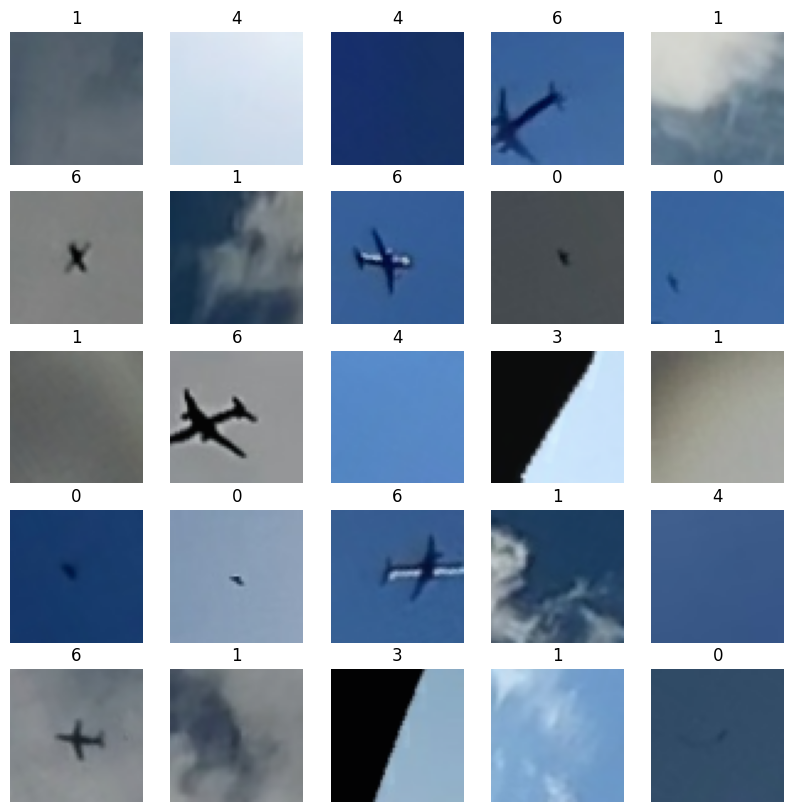

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 54, 54, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 54, 54, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 27, 27, 128)          3584      ['rescaling[0][0]']           
                                                                                                  
 batch_normalization (Batch  (None, 27, 27, 128)          512       ['conv2d[0][0]']              
 Normalization)                                                                               

                                                                                                  
 conv2d_3 (Conv2D)           (None, 4, 4, 728)            373464    ['add_1[0][0]']               
                                                                                                  
 add_2 (Add)                 (None, 4, 4, 728)            0         ['max_pooling2d_2[0][0]',     
                                                                     'conv2d_3[0][0]']            
                                                                                                  
 separable_conv2d_6 (Separa  (None, 4, 4, 1024)           753048    ['add_2[0][0]']               
 bleConv2D)                                                                                       
                                                                                                  
 batch_normalization_7 (Bat  (None, 4, 4, 1024)           4096      ['separable_conv2d_6[0][0]']  
 chNormali

In [6]:
if run_inference:
    inference()
else:
    train()